In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from numpy import arange
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

import shap
shap.initjs()
import warnings
warnings.simplefilter('ignore')

In [2]:
fao_data = pd.read_csv("~/Documents/Kaleb-Bsc thesis/Crop yield and agricultural practices/datasets/latest0705.csv", index_col='Unnamed: 0')

fao_data

,Nutrient nitrogen N (total) - tonnes,Nutrient phosphate P2O5 (total) - tonnes,Nutrient potash K2O (total) - tonnes,Item,Yield(tonnes/ha),Fung & Bact – Benzimidazoles,"Fung & Bact – Diazines, morpholines",Fung & Bact – Dithiocarbamates,Fung & Bact – Inorganics,Fung & Bact – Other,...,Plant Growth Regulators-1,Plant Growth Regulators-2,Rodenticides – Other-1,Rodenticides – Other-2,Herbicides – Bipiridils-1,Herbicides – Bipiridils-2,Herbicides – Sulfonyl ureas-1,Herbicides – Sulfonyl ureas-2,Rodenticides – Anti-coagulants-1,Rodenticides – Anti-coagulants-2
1990-01-01,0.0,0.0,0.0,Apples,26.3272,0.0,0.0,0.0,0.0,0.0,...,1910.0,1910.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,5.0
1990-01-01,0.0,0.0,0.0,Apricots,2.5781,0.0,0.0,0.0,0.0,0.0,...,1910.0,1910.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,5.0
1990-01-01,0.0,0.0,0.0,Cherries,5.0828,0.0,0.0,0.0,0.0,0.0,...,1910.0,1910.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,5.0
1990-01-01,0.0,0.0,0.0,Currants,7.0383,0.0,0.0,0.0,0.0,0.0,...,1910.0,1910.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,5.0
1990-01-01,0.0,0.0,0.0,Gooseberries,6.8081,0.0,0.0,0.0,0.0,0.0,...,1910.0,1910.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-01-01,0.0,0.0,0.0,Mixed grain,-5.8863,0.0,0.0,0.0,0.0,0.0,...,0.0,144.0,0.0,6.0,0.0,-84.0,0.0,4.0,0.1,0.1
2020-01-01,0.0,0.0,0.0,Oats,0.8941,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.1,0.1
2020-01-01,0.0,0.0,0.0,Rye,0.9290,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.1,0.1
2020-01-01,0.0,0.0,0.0,Triticale,0.4421,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.1,0.1


In [3]:
cat_names = fao_data['Category'].unique()
cat_names

array(['Fruits and Nuts', 'Vegetables and Legumes', 'Cereals'],
      dtype=object)

In [4]:
shap_df = pd.DataFrame()

In [6]:
scaler = MinMaxScaler()
for cat in cat_names:
    crop_df = fao_data[fao_data['Category'] == cat]
    encoded_df = pd.get_dummies(crop_df[["Crop_season"]], prefix='', prefix_sep='')
    encoded_df = encoded_df.drop(encoded_df.columns[-2], axis=1)
    y = crop_df[['Yield(tonnes/ha)']]
    x = crop_df.drop(['Yield(tonnes/ha)', "Item", "Category", "Crop_season"], axis=1)
    x = pd.concat([x, encoded_df], axis=1)
    mean = x.mean()
    std = x.std()
    lower_bound = mean - 2 * std
    upper_bound = mean + 2 * std
    x = x.clip(lower_bound, upper_bound, axis=1)
    x = pd.DataFrame(scaler.fit_transform(x), columns=x.columns)
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, shuffle=False)


    regressor = SVR(kernel='poly')
    regressor.fit(x_train, y_train)

    explainer = shap.KernelExplainer(regressor.predict, x_train)
    shap_values = explainer.shap_values(x_test)
    
    plt.title("SHAP Summary Plot (SVR)" + "_" + cat)
    shap.summary_plot(shap_values, x_test)
    plt.show()
    shap_df_crop = pd.DataFrame(shap_values, columns=x_test.columns)
    shap_mean_crop = shap_df_crop.mean()
    shap_df[cat] = shap_mean_crop 
    importances = regressor.feature_importances_
    indices = np.argsort(importances)[-10:]  # select the indices of top 10 features
    features = x_train.columns
    plt.figure(figsize=(10, 6))
    plt.title('Top 10 Feature Importance (SVR) - ' + cat)
    plt.barh(range(len(indices)), importances[indices], color='b', align='center')
    plt.yticks(range(len(indices)), [features[i] for i in indices])
    plt.xlabel('Relative Importance')
    plt.show() 

Using 360 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
  0%|          | 0/90 [00:15<?, ?it/s]


KeyboardInterrupt: 

In [8]:
shap_df = shap_df.add_prefix('mean shap values (SVM)_')
shap_df

,mean shap values (SVM)_Fruits and Nuts,mean shap values (SVM)_Vegetables and Legumes,mean shap values (SVM)_Cereals,mean shap values (SVM)_Industrial_crops
Nutrient nitrogen N (total) - tonnes,0.000000,0.002649,0.014317,0.008844
Nutrient phosphate P2O5 (total) - tonnes,-0.000214,0.000000,-0.001914,-0.003022
Nutrient potash K2O (total) - tonnes,-0.004130,0.024512,-0.000235,-0.000334
Fung & Bact – Benzimidazoles,0.017274,0.002837,0.003637,0.003888
"Fung & Bact – Diazines, morpholines",-0.017017,0.000000,-0.005353,-0.002577
...,...,...,...,...
Plums and sloes,0.001924,NaN,NaN,NaN
Raspberries,-0.068068,NaN,NaN,NaN
Sour cherries,-0.013409,NaN,NaN,NaN
Strawberries,0.033718,NaN,NaN,NaN


In [9]:
shap_df['mean_shap_value'] = shap_df.mean(axis=1)
shap_df

,mean shap values (SVM)_Fruits and Nuts,mean shap values (SVM)_Vegetables and Legumes,mean shap values (SVM)_Cereals,mean shap values (SVM)_Industrial_crops,mean_shap_value
Nutrient nitrogen N (total) - tonnes,0.000000,0.002649,0.014317,0.008844,0.006452
Nutrient phosphate P2O5 (total) - tonnes,-0.000214,0.000000,-0.001914,-0.003022,-0.001287
Nutrient potash K2O (total) - tonnes,-0.004130,0.024512,-0.000235,-0.000334,0.004953
Fung & Bact – Benzimidazoles,0.017274,0.002837,0.003637,0.003888,0.006909
"Fung & Bact – Diazines, morpholines",-0.017017,0.000000,-0.005353,-0.002577,-0.006237
...,...,...,...,...,...
Plums and sloes,0.001924,NaN,NaN,NaN,0.001924
Raspberries,-0.068068,NaN,NaN,NaN,-0.068068
Sour cherries,-0.013409,NaN,NaN,NaN,-0.013409
Strawberries,0.033718,NaN,NaN,NaN,0.033718


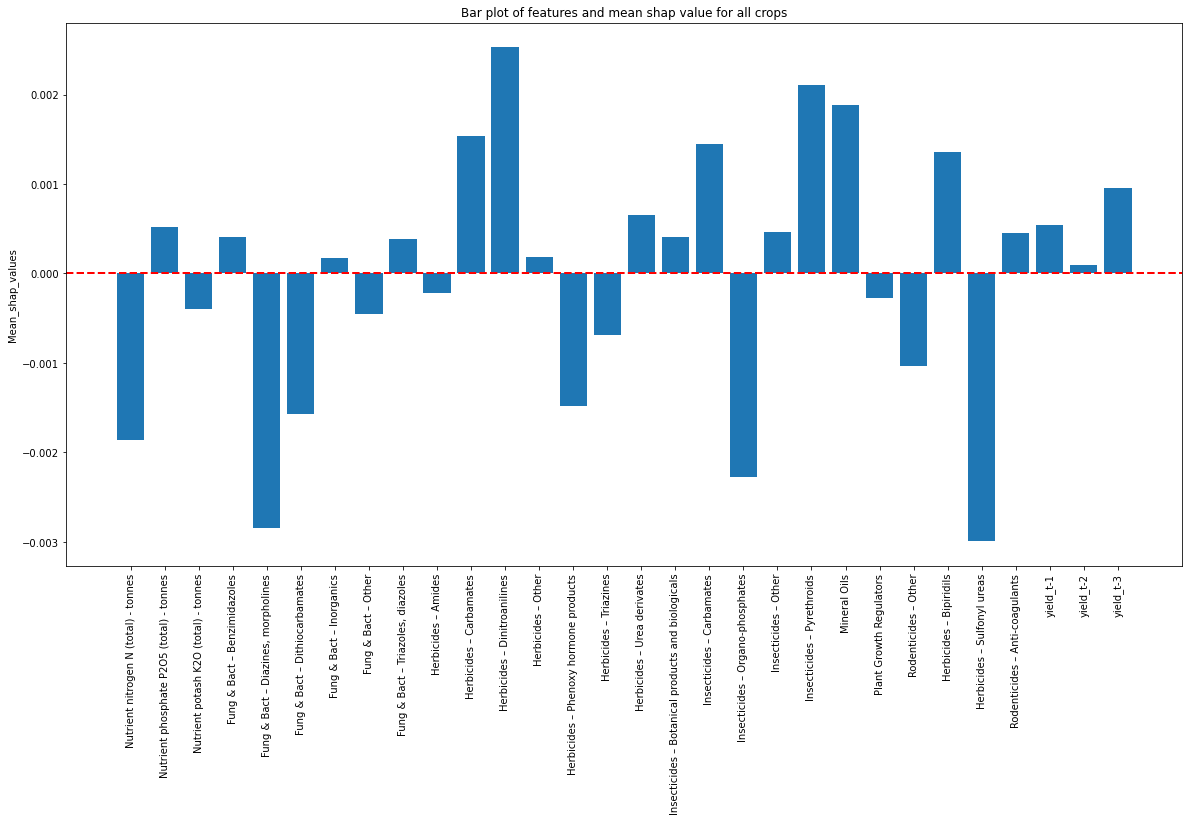

In [14]:
mean_shap = shap_df['mean_shap_value'].mean()
fig, ax = plt.subplots(figsize=(20, 10))
ax.bar(shap_df.index, shap_df['mean_shap_value'])
ax.axhline(mean_shap, color='red', linestyle='dashed', linewidth=2)
ax.set_xticklabels(x, rotation=90)
ax.set_ylabel('Mean_shap_values')
ax.set_title('Bar plot of features and mean shap value for all crops')
plt.show()